In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1,'..')
import numpy as np
import matplotlib.pyplot as plt
from generateFakeData import *
from RmatrixBasedReco import *
from momentBasedReco import *
import qutip as qt

In [3]:
N0 = 2
s = -1 - 2*N0

# Intrinsic Efficiency
eta_intr = 0.5
# Detection efficiency
eta_detection = 1/(1 + N0)
# Total efficiency
eta_total = 1/(1 + N0) * eta_intr

N0_tot = 1/eta_total - 1

print(f'Intrinsic efficency: {eta_intr:.2f}')
print(f'Detection efficency: {eta_detection:.2f}')
print(f'Total efficency: {eta_total:.2f}')
print(f'Total N0: {N0_tot:.2f}')

Intrinsic efficency: 0.50
Detection efficency: 0.33
Total efficency: 0.17
Total N0: 5.00


In [4]:
x_s, p_s = np.linspace(-6, 6, 101), np.linspace(-6, 6, 101)

x, p = np.meshgrid(x_s, p_s, indexing='ij')

sQPD_vac = sQPD_coherent(s, x + 1j*p, 0)
sQPD_fock1 = sQPD_fock(s, x + 1j*p, 1)

### Sampling

In [5]:
N_samples = 1000000
batch_size = 1000000

M = f_coherent(0, 0, s, 0)
# Always samples the vacuum
samples_gnd = sample_from_analytic_distribution(N_samples, f_coherent, (-6, 6, -6, 6), M=M, batch_size=batch_size, s=s, alpha0=0)

samples_sig = sample_from_analytic_distribution(N_samples, f_fock, (-6, 6, -6, 6), M=M, batch_size=batch_size, s=s, n=1)
samples_sig_ineff = np.concatenate([sample_from_analytic_distribution(int(N_samples*eta_intr), f_fock, (-6, 6, -6, 6), M=M, batch_size=batch_size, s=s, n=1), sample_from_analytic_distribution(N_samples - int(N_samples*eta_intr), f_fock, (-6, 6, -6, 6), M=M, batch_size=batch_size, s=s,n=0)])


# Plot checks

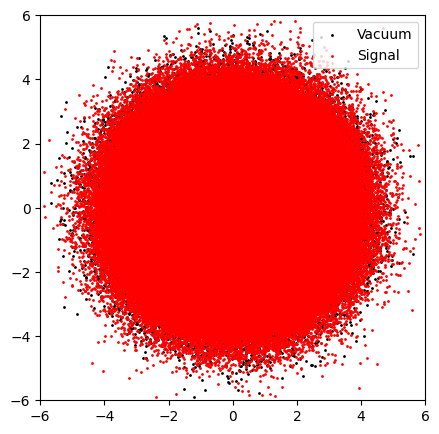

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(samples_gnd.real, samples_gnd.imag, label='Vacuum', color='black', s=1)
ax.scatter(samples_sig.real, samples_sig.imag, label='Signal', color='red', s=1)

ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
ax.set_aspect('equal')
ax.legend(loc='upper right')

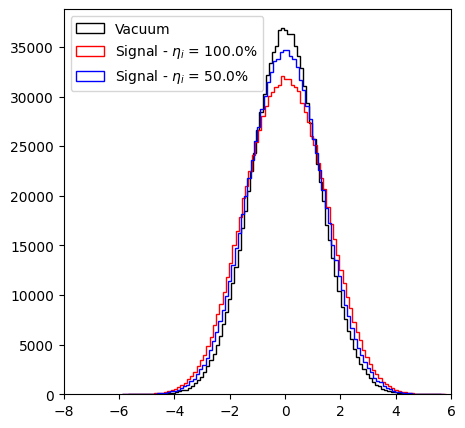

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(samples_gnd.real, 100, label='Vacuum', edgecolor='black', facecolor=None, histtype='step')
ax.hist(samples_sig.real, 100, label=f'Signal - $\\eta_i$ = {100:.1f}%', edgecolor='red', facecolor=None, histtype='step')
ax.hist(samples_sig_ineff.real, 100, label=f'Signal - $\\eta_i$ = {eta_intr*100:.1f}%', edgecolor='blue', facecolor=None, histtype='step')

ax.set_xlim([-8, 6])

ax.legend(loc='best')

# Moments Based Reconstruction (MBR)

In [33]:
# Compute measured moments up to order 2
max_order = 2

# Compute noise moments
therm_moments, therm_moments_unc  = calculate_moments_uncertainty_vectorized(samples_gnd, max_order)

# Compute measured moments up to order 2
meas_moments, meas_moments_unc  = calculate_moments_uncertainty_vectorized(samples_sig, max_order)
meas_ineff_moments, meas_ineff_moments_unc  = calculate_moments_uncertainty_vectorized(samples_sig_ineff, max_order)


In [ ]:
# Compute signal moments in parallel with MonteCarlo
# Highly inefficient. Would not suggest my code for this
# MCsamples = 1000
# gnd_moments, gnd_moments_unc  = extract_a_moments_uncertainty_parallel(therm_moments, therm_moments_unc, therm_moments, max_order, MCsamples)
# sig_moments, sig_moments_unc  = extract_a_moments_uncertainty_parallel(meas_moments, meas_moments_unc, therm_moments, max_order, MCsamples) 
# sig_ineff_moments, sig_ineff_moments_unc  = extract_a_moments_uncertainty_parallel(meas_ineff_moments, meas_ineff_moments_unc, therm_moments, max_order, MCsamples) 

In [34]:
# Compute signal moments with vectorized MonteCarlo
MCsamples = 1000000
gnd_moments, gnd_moments_unc  = extract_a_moments_uncertainty_vectorized(therm_moments, therm_moments_unc, therm_moments, max_order, MCsamples)
sig_moments, sig_moments_unc  = extract_a_moments_uncertainty_vectorized(meas_moments, meas_moments_unc, therm_moments, max_order, MCsamples) 
sig_ineff_moments, sig_ineff_moments_unc  = extract_a_moments_uncertainty_vectorized(meas_ineff_moments, meas_ineff_moments_unc, therm_moments, max_order, MCsamples) 

In [35]:
d = 10

#Maximum Likelihood reconstruction
gnd_rec_MBR = moments_to_density_matrix_ml(gnd_moments, gnd_moments_unc, d)
sig_rec_MBR = moments_to_density_matrix_ml(sig_moments, sig_moments_unc, d)
sig_ineff_rec_MBR = moments_to_density_matrix_ml(sig_ineff_moments, sig_ineff_moments_unc, d)
 

## Plots

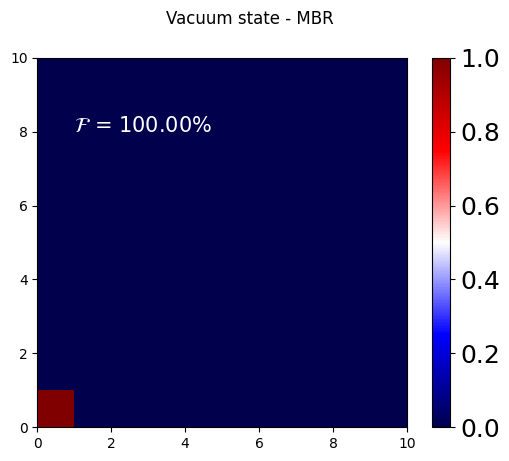

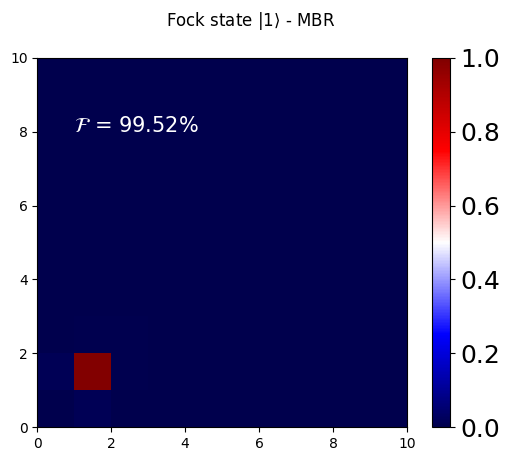

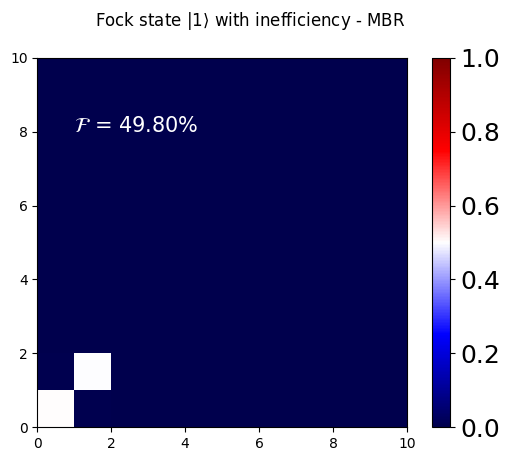

In [36]:
fig, ax = plt.subplots()
fig.suptitle('Vacuum state - MBR')
cm = ax.pcolormesh(np.abs(gnd_rec_MBR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d-2,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(gnd_rec_MBR), qt.fock_dm(d,0))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - MBR')
cm = ax.pcolormesh(np.abs(sig_rec_MBR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d-2,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ with inefficiency - MBR')
cm = ax.pcolormesh(np.abs(sig_ineff_rec_MBR), cmap='seismic', vmin=0, vmax=1)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
ax.text(1,d-2,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_ineff_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15, color='white')
ax.set_aspect('equal', adjustable='box')

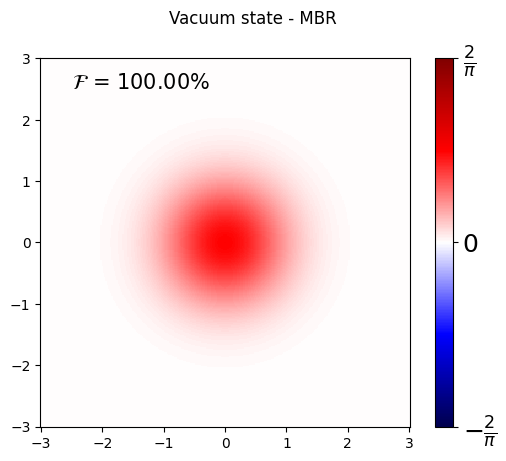

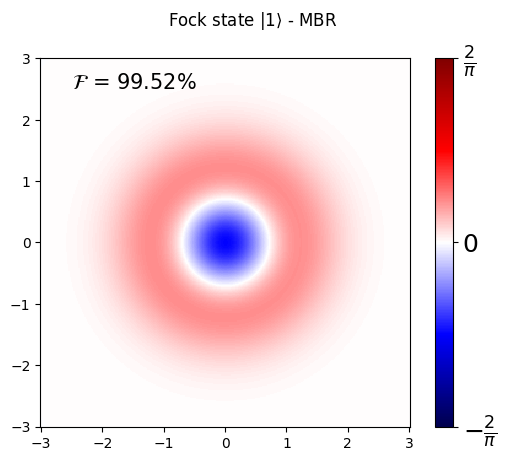

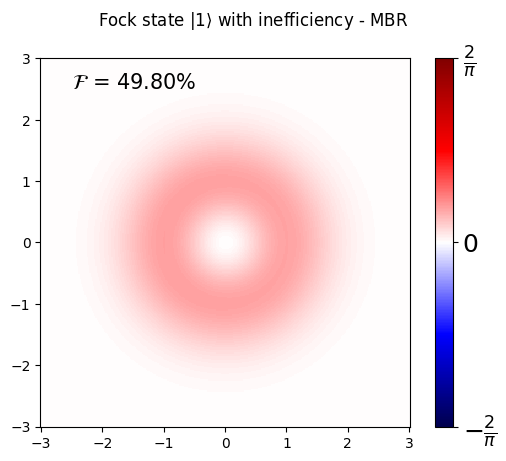

In [37]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Vacuum state - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(gnd_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(gnd_rec_MBR), qt.fock_dm(d,0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ with inefficiency - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_ineff_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_ineff_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

In [38]:
print('g2 thermal from moments: ', g2_from_moments(therm_moments))
print()
print('g2 signal from density matrix: ', g2_from_density_matrix(sig_rec_MBR))
print(f'g2 signal with intrinsic inefficiency ({eta_intr*100:.1f}%) from density matrix: ', g2_from_density_matrix(sig_ineff_rec_MBR))
print()
print('g2 signal from moments: ', g2_from_moments_with_uncertainty(sig_moments, sig_moments_unc)[0], ' +/- ', g2_from_moments_with_uncertainty(sig_moments, sig_moments_unc)[1])
print(f'g2 signal with intrinsic inefficiency ({eta_intr*100:.1f}%) from moments: ', g2_from_moments_with_uncertainty(sig_ineff_moments, sig_ineff_moments_unc)[0], ' +/- ', g2_from_moments_with_uncertainty(sig_ineff_moments, sig_ineff_moments_unc)[1])



g2 thermal from moments:  1.9976430299844896

g2 signal from density matrix:  0.009233587985791818
g2 signal with intrinsic inefficiency (50.0%) from density matrix:  0.08398358125010108

g2 signal from moments:  -0.028806689114021802  +/-  0.0740110495129732
g2 signal with intrinsic inefficiency (50.0%) from moments:  0.08398534484937054  +/-  0.2601449281825594


# $R \rho R$ reconstruction

### Not using G matrix

Iteration: 33989/100000 | Percentage: 22.56% | |maxEig(R)-1|: 2.82e-04 > 6.36e-05 | Log-Likelihood: -3.2512
No significant improvement in the last 100 iterations. Stopping iterations.


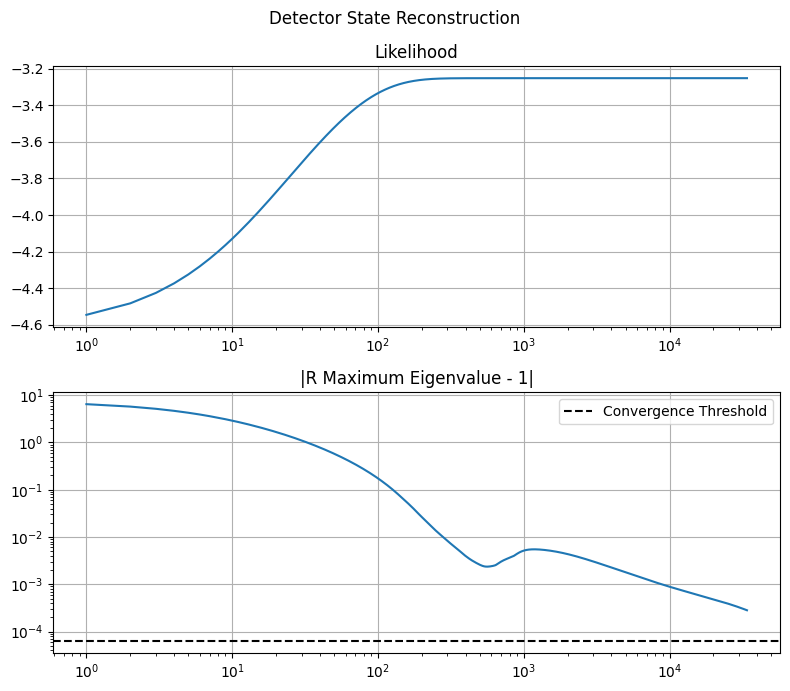

In [ ]:
d = 30
nbins = 31

tol = 0.1

counts, alphas = prepare_histograms(np.squeeze(samples_gnd), nbins)
povm_list = [coherent_state_povm(alpha, d) for alpha in alphas]
therm_rec_RrhorR, therm_lik_RrhorR, therm_eig_RrhorR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=100000, dilution=1e-2, tol=tol, improvement_tol=1e-10, patience=100, track_likelihood=True)

fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Detector State Reconstruction')
ax[0].plot(np.arange(1, len(therm_lik_RrhorR)+1), therm_lik_RrhorR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(therm_eig_RrhorR)+1), np.abs(therm_eig_RrhorR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  
fig.tight_layout()

Iteration: 5274/50000 | Percentage: 100.01% | |maxEig(R)-1|: 6.36e-06 > 6.36e-06 | Log-Likelihood: -3.5352
Converged in 5275 iterations (|maxEig(R)-1| = 6.36e-06).


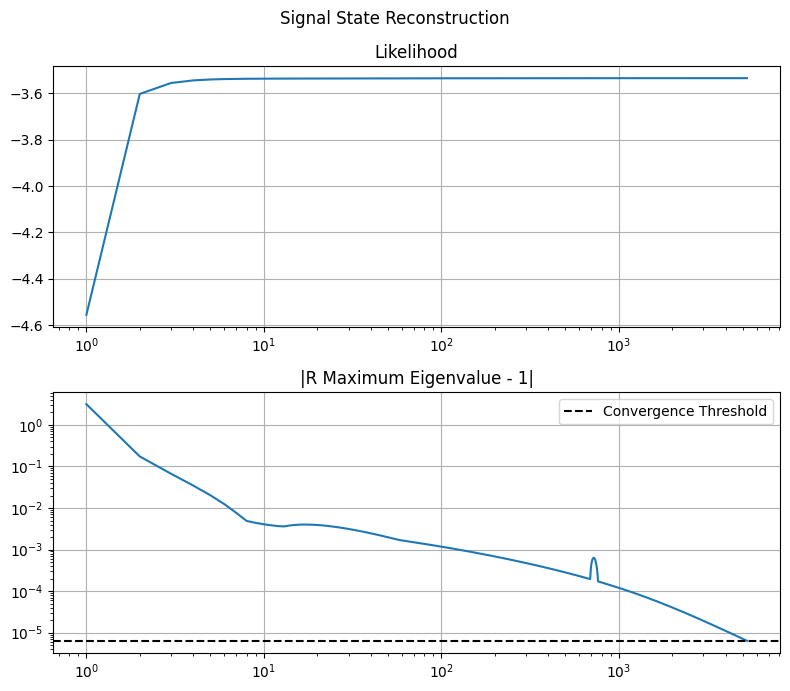

In [112]:
tol = 1e-2


counts, alphas = prepare_histograms(np.squeeze(samples_sig), nbins)
povm_list = [displaced_thermal_povm(alpha, N0, d) for alpha in alphas]
sig_rec_RrhoR, sig_lik_RrhoR, sig_eig_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=50000, dilution=None, tol=tol, improvement_tol=1e-10, patience=100, track_likelihood=True)
fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Signal State Reconstruction')
ax[0].plot(np.arange(1, len(sig_lik_RrhoR)+1), sig_lik_RrhoR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(sig_eig_RrhoR)+1), np.abs(sig_eig_RrhoR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  
fig.tight_layout()


Iteration: 5201/50000 | Percentage: 100.01% | |maxEig(R)-1|: 6.36e-06 > 6.36e-06 | Log-Likelihood: -3.4050
Converged in 5202 iterations (|maxEig(R)-1| = 6.36e-06).


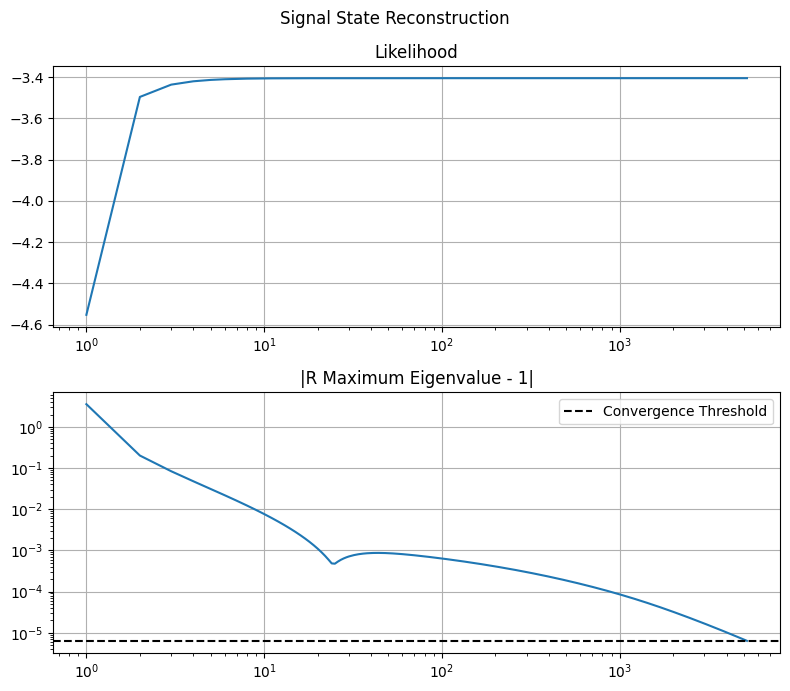

In [113]:
tol = 1e-2


counts, alphas = prepare_histograms(np.squeeze(samples_sig_ineff), nbins)
povm_list = [displaced_thermal_povm(alpha, N0, d) for alpha in alphas]
sig_ineff_rec_RrhoR, sig_ineff_lik_RrhoR, sig_ineff_eig_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=50000, dilution=None, tol=tol, improvement_tol=1e-10, patience=1000, track_likelihood=True)
fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Signal State Reconstruction')
ax[0].plot(np.arange(1, len(sig_ineff_lik_RrhoR)+1), sig_ineff_lik_RrhoR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(sig_ineff_eig_RrhoR)+1), np.abs(sig_ineff_eig_RrhoR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  
fig.tight_layout()

#### Plots

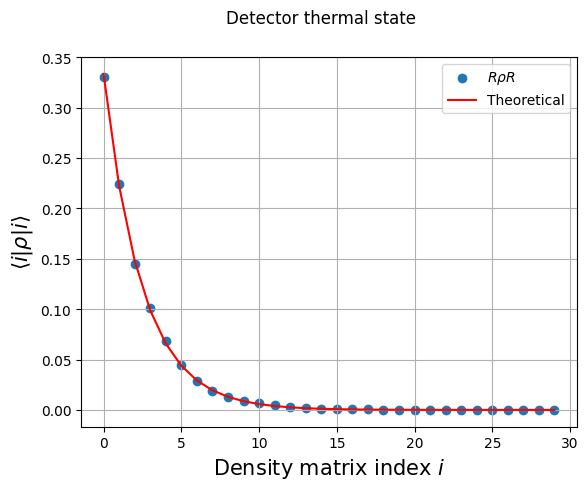

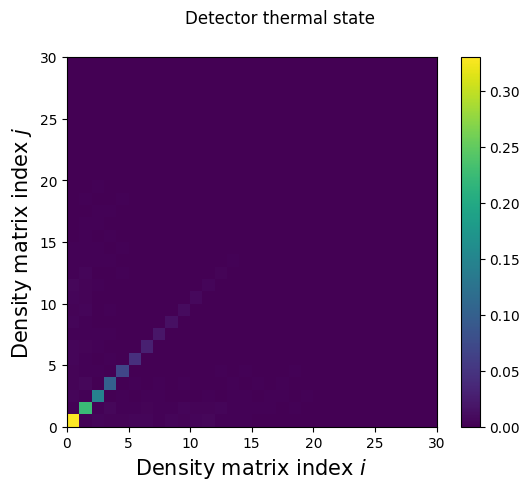

In [114]:
fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
ax.scatter(np.arange(0,d),np.diagonal(np.abs(therm_rec_RrhorR)), label='$R \\rho R$')
ax.plot(np.arange(0,d), np.diagonal(np.abs(qt.thermal_dm(d, N0).full())), color='red', label='Theoretical')
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('$\\langle i|\\rho|i \\rangle$', fontsize=15)
ax.grid()
ax.legend()


fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
cb = ax.pcolormesh(np.abs(therm_rec_RrhorR))
fig.colorbar(cb)
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('Density matrix index $j$', fontsize=15)
ax.set_aspect('equal')

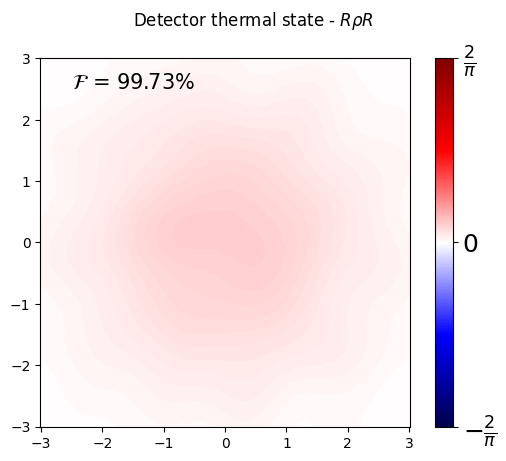

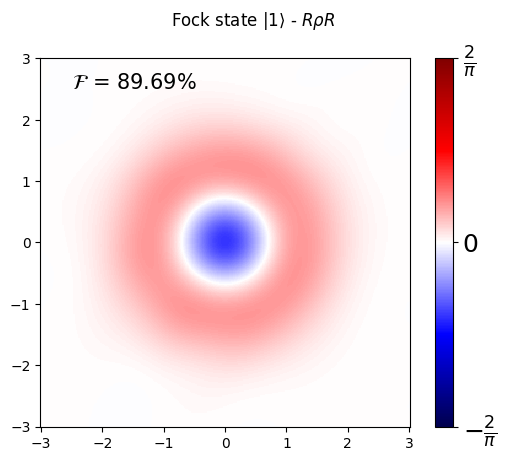

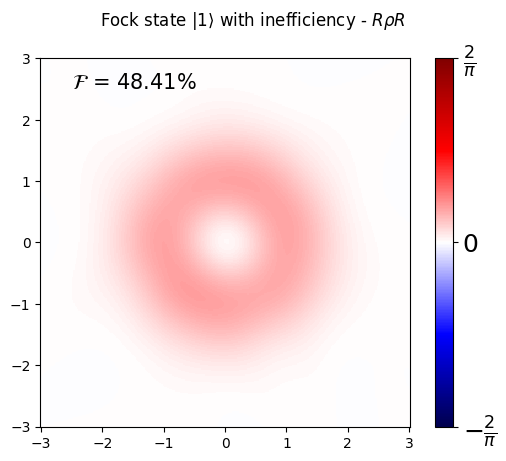

In [115]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Detector thermal state - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(therm_rec_RrhorR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(therm_rec_RrhorR), qt.thermal_dm(d,N0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ with inefficiency - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_ineff_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_ineff_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


### Using G matrix

Iteration: 16695/100000 | Percentage: 30.72% | |maxEig(R)-1|: 2.07e-04 > 6.36e-05 | Log-Likelihood: -3.2513
No significant improvement in the last 100 iterations. Stopping iterations.


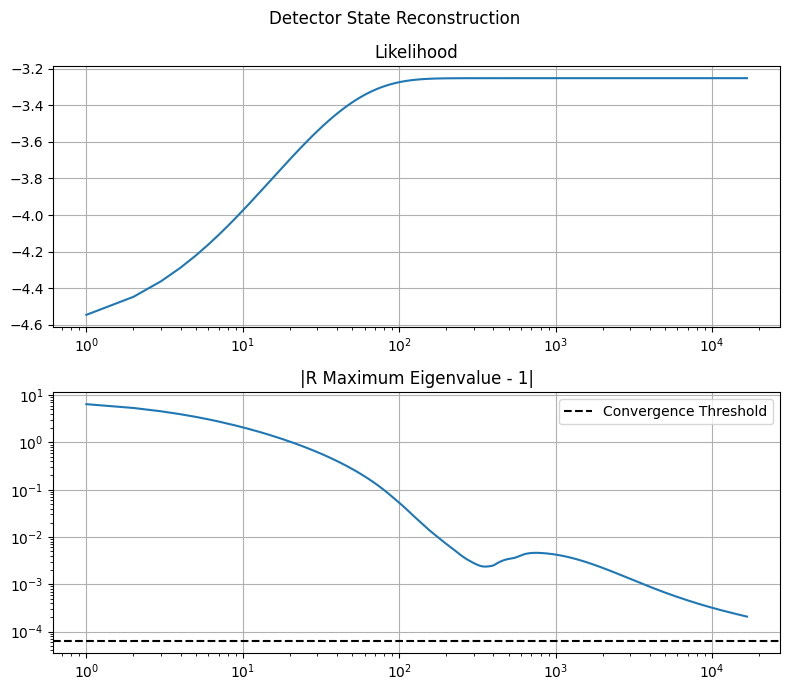

In [ ]:
d = 30
nbins = 31

tol = 0.1

counts, alphas = prepare_histograms(np.squeeze(samples_gnd), nbins)
povm_list = [coherent_state_povm(alpha, d) for alpha in alphas]
therm_rec_RrhorR, therm_lik_RrhorR, therm_eig_RrhorR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=100000, useG=True, dilution=1e-1, tol=tol, improvement_tol=1e-10, patience=100, track_likelihood=True)

fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Detector State Reconstruction')
ax[0].plot(np.arange(1, len(therm_lik_RrhorR)+1), therm_lik_RrhorR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(therm_eig_RrhorR)+1), np.abs(therm_eig_RrhorR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  
fig.tight_layout()

Iteration: 15994/50000 | Percentage: 92.75% | |maxEig(R)-1|: 6.86e-06 > 6.36e-06 | Log-Likelihood: -3.5352
No significant improvement in the last 1000 iterations. Stopping iterations.


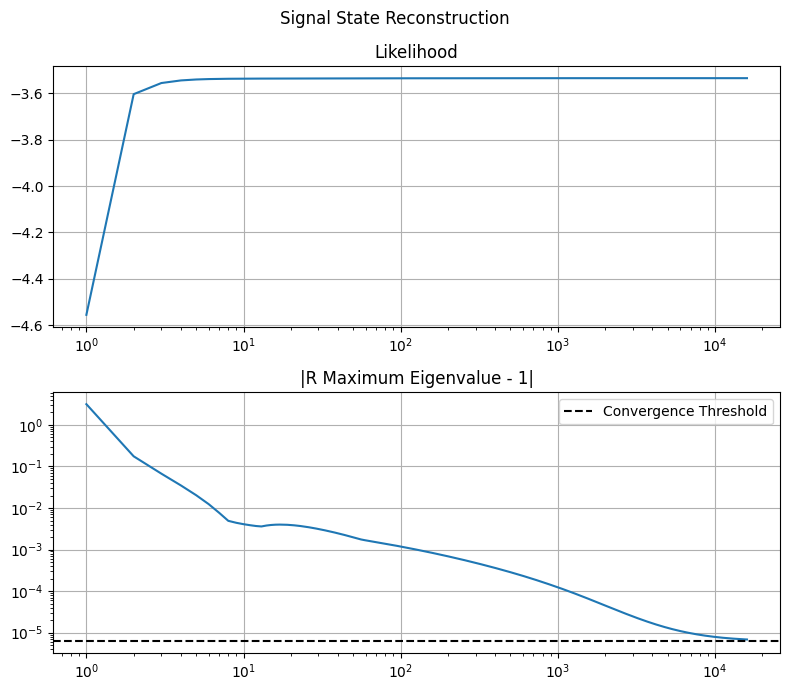

In [109]:
tol = 1e-2


counts, alphas = prepare_histograms(np.squeeze(samples_sig), nbins)
povm_list = [displaced_thermal_povm(alpha, N0, d) for alpha in alphas]
sig_rec_RrhoR, sig_lik_RrhoR, sig_eig_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=50000, useG=True, dilution=None, tol=tol, improvement_tol=1e-10, patience=1000, track_likelihood=True)
fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Signal State Reconstruction')
ax[0].plot(np.arange(1, len(sig_lik_RrhoR)+1), sig_lik_RrhoR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(sig_eig_RrhoR)+1), np.abs(sig_eig_RrhoR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  
fig.tight_layout()


Iteration: 5964/50000 | Percentage: 100.02% | |maxEig(R)-1|: 6.36e-06 > 6.36e-06 | Log-Likelihood: -3.4050
Converged in 5965 iterations (|maxEig(R)-1| = 6.36e-06).


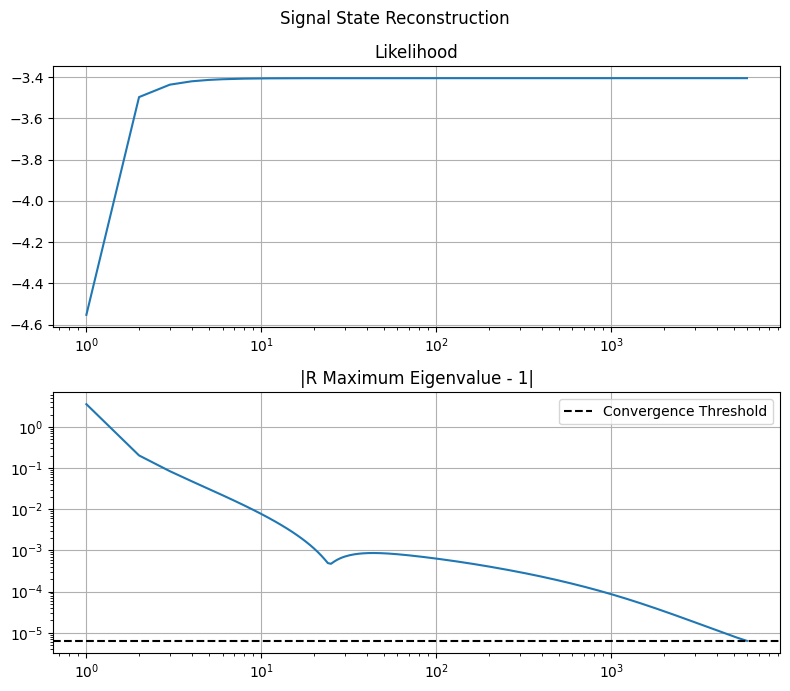

In [108]:
tol = 1e-2


counts, alphas = prepare_histograms(np.squeeze(samples_sig_ineff), nbins)
povm_list = [displaced_thermal_povm(alpha, N0, d) for alpha in alphas]
sig_ineff_rec_RrhoR, sig_ineff_lik_RrhoR, sig_ineff_eig_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=50000, useG=True, dilution=None, tol=tol, improvement_tol=1e-10 , patience=1000, track_likelihood=True)
fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Signal State Reconstruction')
ax[0].plot(np.arange(1, len(sig_ineff_lik_RrhoR)+1), sig_ineff_lik_RrhoR)
ax[0].set_title('Likelihood')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot(np.arange(1, len(sig_ineff_eig_RrhoR)+1), np.abs(sig_ineff_eig_RrhoR)-1)
ax[1].axhline(tol*np.sqrt((len(povm_list)**2 - 1) / 2) / np.sum(counts), color='black', linestyle='--', label='Convergence Threshold')
ax[1].set_title('|R Maximum Eigenvalue - 1|')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()  
fig.tight_layout()

#### Plots

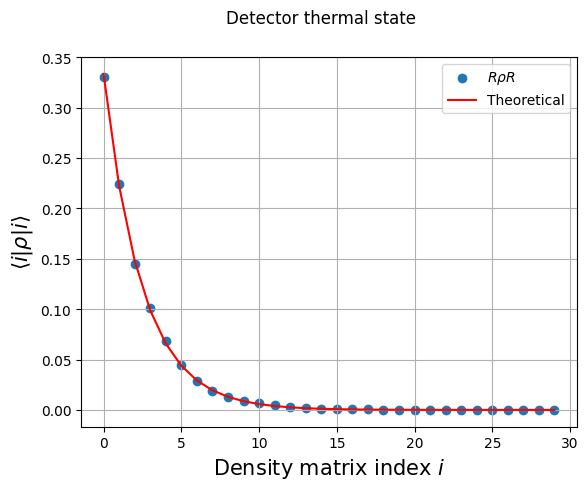

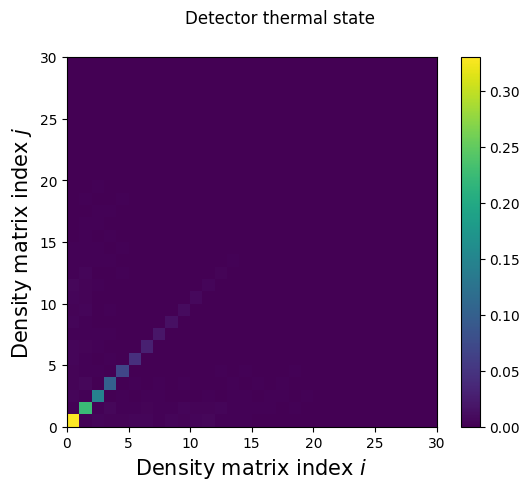

In [110]:
fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
ax.scatter(np.arange(0,d),np.diagonal(np.abs(therm_rec_RrhorR)), label='$R \\rho R$')
ax.plot(np.arange(0,d), np.diagonal(np.abs(qt.thermal_dm(d, N0).full())), color='red', label='Theoretical')
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('$\\langle i|\\rho|i \\rangle$', fontsize=15)
ax.grid()
ax.legend()


fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
cb = ax.pcolormesh(np.abs(therm_rec_RrhorR))
fig.colorbar(cb)
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('Density matrix index $j$', fontsize=15)
ax.set_aspect('equal')

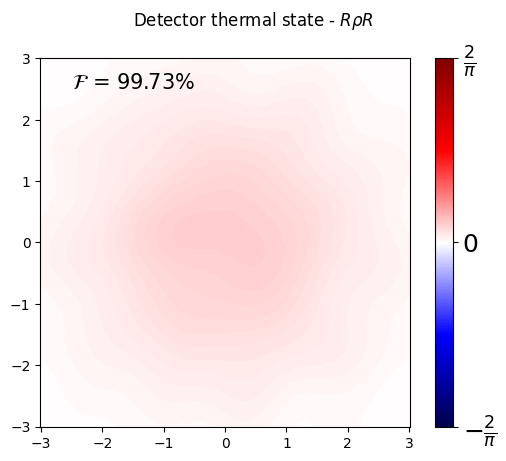

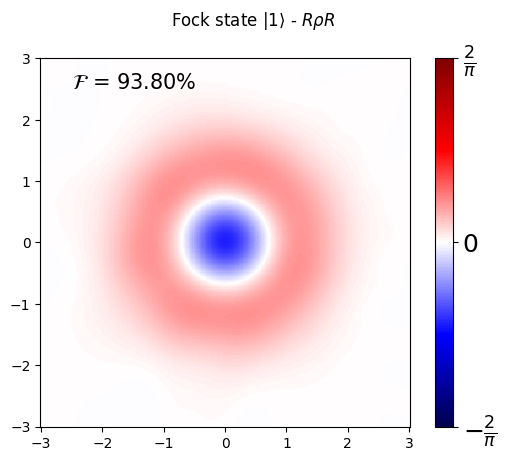

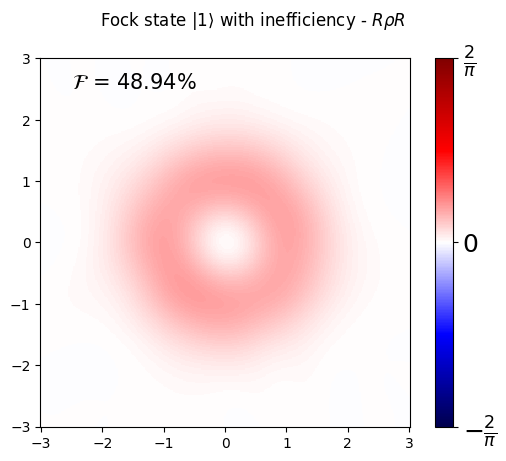

In [111]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Detector thermal state - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(therm_rec_RrhorR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(therm_rec_RrhorR), qt.thermal_dm(d,N0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ with inefficiency - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_ineff_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_ineff_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')
